# Starbucks Capstone Challenge Notebook



## Background : 

The businesses want to target right customers throughout the customer journey which helps to reduce the marketing budget, customer satisfaction as well increase the profits.  Machine learning (ML) and artificial intelligence (AI) technologies are helping automate the digital marketing with real time decision making such as selecting best messaging platform, best timing, and the best offer to the individual customer by integrating data from different platforms [1-4].

Udacity's Starbucks Capstone challenge project  data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Machine learning technique will be used in order to develop effective marketing strategy for the Starbucks business using the available data.  


# Problem Statement 

Starbucks sends out an offer to users of the mobile app every few days. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The given dataset contains demographic data record of transaction and details about offer information. This project is divided in three parts.

It is important to know your customers in order to increase business. First, customer segmentation using unsupervised machine learning technique K-means clustering is carried out to understand current customer characteristics and demographics. Second  the best performing supervised machine learning model is built by comparing linear classifier, random forest, decison tree, gradient boost and ada boost ensemble models performance based on the CM, ROC curve to predict if customer will respond to an offer or not for better targeted marketing. 


## Following are the project design steps carried out to execute this project


1. Data cleaning and exploratory data analysis (EDA)


2. Feature engineering - Create new features from the 
 

3. Customer segmentation to know Starbucks current customers charecteristics

4.  Offer prediction model - the best performing supervised machine learning model will be build by comparing random forest and boosting ensemble models based on the metrics to predict if customer will respond to an offer or not for better targeted marketing. 
    
# Challanges 

- Not all users receive the same offer
- Different validity period for the offer type and informational offer to influence customer.
- Customer might make a purchase through the app without having received an offer or seen an offer
- A user can receive an offer, never actually view the offer, and still complete the offer


In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib





# Part 1 :  Initial Dataset Statistics and basic EDA



### Portfolio Dataset

In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('portfolio shape {}:' .format(portfolio.shape)) 
print('portfolio statistics:' ) 
print((portfolio.describe()))
print('portfolio null count:') 
print((portfolio.isnull().sum()))
 

portfolio shape (10, 6):
portfolio statistics:
       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000
portfolio null count:
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


No missing values. 

In [3]:
print('portfolio data charecteristics  {}:' .format(portfolio.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
portfolio data charecteristics  None:


In [4]:
# cleaning function portfolio
# credit -  https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# credit - https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
# credit -https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list/45312577#45312577

def portfolio_clean(portfolio):

    """ 
    Clean, select and transform a DataFrame containing information about offer type and duration
    INPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        portfolio: clean transformed portfolio DataFrame
    """  
    
    portfolio = portfolio.assign(**pd.get_dummies(portfolio.channels.apply(lambda x:pd.Series(x)).stack()
                                                    .reset_index(level=1,drop=True)).sum(level=0))
    portfolio = portfolio.assign(**pd.get_dummies(portfolio.offer_type.apply(lambda x:pd.Series(x)).stack()
                                                   .reset_index(level=1,drop=True)).sum(level=0))
    #portfolio['id'] = [offer_id_col[item] for item in portfolio_df['id']] 
    portfolio.rename(columns={'id':'offer_id', 'reward': 'reward_offered'}, inplace =True)
    
    offer_type_col = {'bogo':'1', 'informational':'2','discount':'3'}
    #portfolio['offer_type'] = [offer_type_col[item] for item in portfolio['offer_type']] 
    
    portfolio.drop(['channels'], axis=1, inplace=True)
    
    return portfolio



In [5]:
portfolio_df=portfolio_clean(portfolio)

### Summary of  portfolio dataset and statistics
- Encode offer_type columns
- No direct reward for the information type offer so we will need a strategy to check its offer effetiveness
- duration will be helpful to seperate offer and transaction dataframes for further analysis. 
- Channel feature does not look much helpful. We can see that all the offers have been sent through mobile and email with an exception. 
- We will not use channel feature in our model or segmentation. 
- 4 types of bogo, 4 types of discount and 2 types of informational offers were sent. 
- Offer duration - what is expected from the offer duration if its too long or too short, it may not be effective. We will see the when we will complete the analysis. 
- Difficulty - it's minium amount to be spent to complete offer. We need to see average amount spend and compare difficulty to see what's effective difficulty level. 

In [6]:
portfolio_df

,difficulty,duration,offer_id,offer_type,reward_offered,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


### Profile Dataset

In [7]:
# read in the json files
profile = pd.read_json('profile.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('profile  shape is {}:' .format(profile.shape)) 
print('profile statistics  {}:' .format(profile.describe())) 
print('profile data charecteristics   {}:' .format(profile.info())) 
print('profile null count{}:' .format(profile.isnull().sum()))

profile  shape is (17000, 5):
profile statistics                  age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
profile data charecteristics   None:
profile null countage                    0
became_memb

Missing values in gender and income. 
Age maximum - 118 - looks like a outlier. We will do missing data analysis. 

In [8]:
# cleaning function profile
# credit -  https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
import datetime

def profile_clean(profile):

    """ 
    Clean, select and transform a DataFrame containing a demographic data for each customer
    INPUT:
        profile: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        profile: clean and transformed profile DataFrame
    """  
  
    # We can calculate membershipt years using became member on data to see how long customer is starbucks member
    profile['date_time'] =pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
    end_time =(datetime.datetime.today().date())
    start_time =(profile['date_time'].dt.date)
    
    profile['membership_years']=  (end_time -start_time)
    profile['membership_years'] = round((pd.to_numeric(profile['membership_years'].dt.days, downcast='integer')/365),)
   
    # let's fill na with unknown gender.
    profile.fillna(profile.mean(), inplace=True)
    profile.fillna(profile.mean(), inplace=True)
   
    profile['year'] = pd.DatetimeIndex(profile['date_time']).year   

    profile.rename(columns={'id':'customer_id'}, inplace =True)
    profile.drop(['date_time', 'became_member_on'], axis=1,inplace=True)

    return profile


In [9]:
profile_df=profile_clean(profile)

In [10]:
profile_df.head()

,age,gender,customer_id,income,membership_years,year
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,3.0,2017
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,3.0,2017
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2.0,2018
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,3.0,2017
4,118,None,a03223e636434f42ac4c3df47e8bac43,65404.991568,3.0,2017


###  Summary of profile dataframe
- Important dataset for the understanding customer demographic. 
- age, gender catgorical features encode later
- become_member_on  changed to membership years.
- age maximum value : 118 - looks like outlier
- income and gender columns have more missing values - 2175 which are corresponding to age outlier. We will check overall missing values in the combined dataset to decided if we need to impute or delete missing values.

### Transcript Dataset

In [11]:
# read in the json files
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('transcript  shape is {}: ' .format(transcript.shape)) 
print('transcript statistics:' )
print(transcript.describe()) 
print('transcript data charecteristics:')
print(transcript.info())
print('transcript null count:' )
print(transcript.isnull().sum())

transcript  shape is (306534, 4): 
transcript statistics:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
transcript data charecteristics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
transcript null count:
event     0
person    0
time      0
value     0
dtype: int64


No missing values. 
Value column has dictionary. It contains offer id, reward and amount

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
# transcript value contains amount related to transaction, offer id and reward given 
transcript.tail(5)

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [14]:
# let's check what value discitonary includes. 
transcript.value.value_counts().head(15)

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                 14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                 14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                 14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                 14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                 14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                 14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                 11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                 11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                 11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                 10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}     5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}     5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}     4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}     4296
{'offe

In [15]:
# cleaning function transcript
# credit - https://stackoverflow.com/questions/58383927/convert-series-of-dict-and-concat-to-dataframe
#https://stackoverflow.com/questions/38134012/pandas-dataframe-fillna-only-some-columns-in-place

def transcript_clean(transcript):

    """ 
    Clean, select and transform a DataFrame containing the records for transactions,
    offer types : received, viewed, completed
    INPUT:
        transcript: DataFrame containing records of transaction, customer id, time and value
                   each offer (duration, type, etc.)
    OUTPUT:
        transcript: clean and transformed transcript DataFrame
    """  
    # value column contains disctionary with amount, reward and offer id 
    # it results in nan columns which we will clean later
    transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
    
    # we will delete offer id column , it contains duplicate/missing information from offer_id related to reward - 
    #we can fill that information from offer_id column - reward offer id
    transcript['offer_id'].fillna(transcript['offer id'],inplace=True)
    transcript.rename(columns={'person':'customer_id', 'reward':'reward_given'}, inplace =True)
    
    #convert number of days - time column to 
    transcript['time'] = round(transcript['time']/24).astype(int)
    #transcript= pd.concat([transcript, pd.get_dummies(transcript['event'])], axis= 1)
    transcript.drop(['value', 'offer id'], axis=1,inplace=True)

    return transcript

In [16]:
transcript_df=transcript_clean(transcript)

In [17]:
transcript_df.head()

,event,customer_id,time,amount,offer_id,reward_given
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


###  Summary of Transcript dataframe

###  Missing Data analysis 
Rule of thumb, if there is less than 5% of missing data and features are not important then we can delete. However, We have almost 12.79% missing customers profile. It belongs to gender and income  columns. To further understand mising data : We will have a closer look at the transcript and profile combined dataframe. We can check that how it can affect overall segmentation analysis and offer predictions modeling. 

In [18]:
profile.rename(columns={'id':'customer_id'}, inplace =True)
#profile.drop(['reward_given', 'date_time id'], axis=1,inplace=True)
df_merged=pd.merge(transcript_df,  profile_df, on='customer_id', how='left')
df_temp=pd.merge(df_merged,  portfolio_df, on='offer_id', how='left')

In [19]:
df_merged.head()

,event,customer_id,time,amount,offer_id,reward_given,age,gender,income,membership_years,year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.000000,3.0,2017
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,None,65404.991568,3.0,2017
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68,M,70000.000000,2.0,2018
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,118,None,65404.991568,2.0,2017
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,None,65404.991568,2.0,2017


In [20]:
print('Missing offer completed data  due to missing  gender and age data')
print(df_merged[(df_merged['gender'].isna())&(df_merged['event']=='offer completed')
               ].customer_id.count()*100/df_merged[(df_merged['event']=='offer completed')].customer_id.count())   

Missing offer completed data  due to missing  gender and age data
3.3800887459424045


In [21]:
print('Missing data percentage in the profile dataset ')
print(profile.isna().sum()*100/(profile.customer_id.count()))

Missing data percentage in the profile dataset 
age                  0.000000
gender              12.794118
customer_id          0.000000
income               0.000000
membership_years     0.000000
year                 0.000000
dtype: float64


In [22]:
print('Missing transaction related data due to missing gender and age data')
print(df_merged[(df_merged['gender'].isna())&(df_merged['event']=='transaction')
               ].customer_id.count()*100/df_merged[(df_merged['event']=='transaction')].customer_id.count())   

Missing transaction related data due to missing gender and age data
10.79213834893813


###  Missing Data Imputation
We will impute age and gender values with mean and median values. 


In [25]:
 # only gender and income column showed nan values. We will clean the data # dropped data comment
# fill gender as unknown - other -O
df_temp.gender.fillna('O', inplace =True)
# we will replace age with mean
mean_age=df_temp.age.mean
df_temp['age'].replace(to_replace=[118], value=mean_age,inplace=True)
    
    

### Exploratory Data Analysis (EDA)  

### 1. Offer Type 

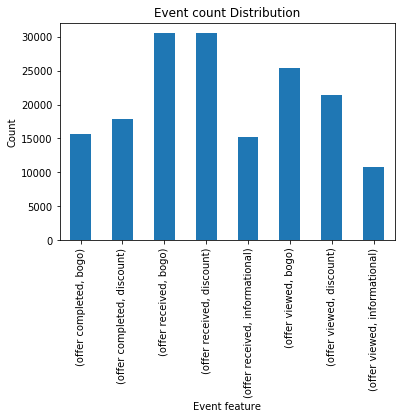

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: customer_id, dtype: int64 event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: customer_id, dtype: int64


In [53]:
#Let's check different offer type and transactions event counts

#Let's check offer type count by event
df_temp.groupby(['event','offer_type'])['customer_id'].count().plot.bar()

plt.xlabel('Event feature')
plt.ylabel('Count')
plt.title('Event count Distribution')
plt.show()
list1=df_temp.groupby(['event']).customer_id.count()
list2=df_temp.groupby(['event','offer_type'])['customer_id'].count()
print(list1,list2)

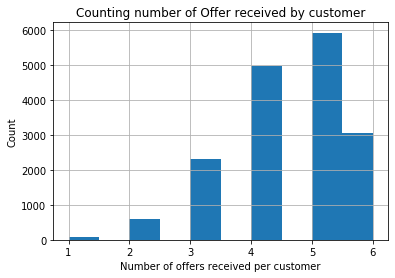

Offer completed transaction count  24.165725101293244  % from customer transactions
and many customers recieved more than 4 offers.


In [55]:
#### Let's see hpw many offers recieved per customers

df_temp[df_temp['event']=='offer received'].groupby('customer_id')['event'].count().hist()
plt.xlabel('Number of offers received per customer')
plt.ylabel('Count')
plt.title('Counting number of Offer received by customer')
plt.show()

# we have not seperated informational offer transactions. 
print('Offer completed transaction count ',(df_temp[(df_temp['event']=='offer completed')].customer_id.count()*100/
                                           df_temp[(df_temp['event']=='transaction')].event.count()),' % from customer transactions' )
print('and many customers recieved more than 4 offers.')

- ### Offer Type Analysis

- Almost same number of bogo and discount offers were sent to the customers. 
- Bogo offer : More bogo offers were viewed as compared to dicount offers. However, bogo offer view rate is above 80% and bogo
  offer completion rate is around 50%. 
- Discount offer : More discount offers were completed as compared to bogo offers. Discount offer view rate is around 85% and
  offer completion rate is 58%
- Informational offer - offer view rate is around 70%, We will calculate informational offer completion rate later. 
- Overall, offer completion rate 45% and offer view rate is 76%. We need to count informational offer related transaction later. and informational offer completion rate. 
- 45% transaction data and 24% offer related transaction data. 

In [ ]:
# Starbuck has more male customers. membership year and gender plot 

In [ ]:
df_merged.head()

In [ ]:
import seaborn as sns
#df_merged.groupby('membership_years')['gender'].count().plot.bar()
#import seaborn as sns
#sns.barplot(x=df_temp.gender.value_counts().index, y=df_temp.membership_years.value_counts())

sns.countplot(x='membership_years', hue="gender", data=df_merged)

In [ ]:
sns.countplot(x='year', hue="gender", data=df_merged)

In [ ]:
# Let's check how many rewards are given overall 
#df_temp.groupby('offer_type')['reward_given'].count().plot.bar()

## Part II
  scaling, and feature engineering. 


offer_completion_rate = Number of completed offers trasaction / Number of offers sent (all offers sum)
# Lets check how many offer related transaction
54% of data will be used to charecterize demographic#http://fluidsurveys.com/university/difference-response-rate-completion-rate/
# offer completion rate 
#df_temp2['offer_completion_rate'] =

In [ ]:
df_merged.head()

In [ ]:
df_merged.columns

In [ ]:
df_merged=df_merged.merge(portfolio_df, on='offer_id', how='left')

# sort by 'customer_id','offer_id','time'
df_merged.sort_values(by=['customer_id','offer_id','time'], inplace=True)

# rearrange columns
df_merged = df_merged[['customer_id', 'offer_id', 'time', 'event', 'amount', 'reward_given', \
                     'difficulty', 'duration', 'offer_type', 'reward_offered','age', 'gender', 'income', 'membership_years', 'year']]

# rename columns
#df_merged.columns = ['customer_id', 'offer_id', 'time', 'event', 'amount', 'reward_given', \
                     #'difficulty', 'duration', 'offer_type', 'reward_offered']
# Create a copy
df_temp = df_merged.copy()

In [ ]:
df_temp.head()

In [ ]:
df_temp['offer_success'] = 0

df_temp.loc[( ((df_temp.offer_type=='discount') | (df_temp.offer_type=='bogo' ))\
        &( df_temp.customer_id==df_temp.customer_id.shift(1) )\
        &( df_temp.offer_id==df_temp.offer_id.shift(1) )\
        &( df_temp.offer_type==df_temp.offer_type.shift(1) )\
        &( df_temp.customer_id==df_temp.customer_id.shift(2) )\
        &( df_temp.offer_id==df_temp.offer_id.shift(2) )\
        &( df_temp.offer_type==df_temp.offer_type.shift(2) )\
        &( df_temp.event=='offer completed' )\
        &( df_temp.event.shift(1)=='offer viewed')\
        &( df_temp.event.shift(2)=='offer received' )\
        &( (df_temp.time-df_temp.time.shift(1)) <= df_temp.duration )\
        &( (df_temp.time-df_temp.time.shift(2)) <= df_temp.duration )\
        &( (df_temp.time-df_temp.time.shift(1)) >=0 )\
        &( (df_temp.time-df_temp.time.shift(2)) >=0 ) \
       ), 'offer_success'] = 1

In [ ]:
df_temp.loc[( (df_temp.offer_type=='informational')\
        &( df_temp.customer_id==df_temp.customer_id.shift(1) )\
        &( df_temp.offer_id==df_temp.offer_id.shift(1) )\
        &( df_temp.offer_type==df_temp.offer_type.shift(1) )\
        &( df_temp.event=='offer viewed' )\
        &( df_temp.event.shift(1)=='offer received')\
        &( (df_temp.time-df_temp.time.shift(1)) <= df_temp.duration )\
        &( (df_temp.time-df_temp.time.shift(1)) >=0 )\
#         &( (df.time-df.time.shift(2)) >=0 ) \
       ), 'offer_success'] = 1

In [ ]:
df_temp['offer_completed_informational']=0
offer_completed_informational =df_temp.loc[( (df_temp.offer_type=='informational')\
        &( df_temp.customer_id==df_temp.customer_id.shift(1) )\
        &( df_temp.offer_id==df_temp.offer_id.shift(1) )\
        &( df_temp.offer_type==df_temp.offer_type.shift(1) )\
        &( df_temp.event=='offer viewed' )\
        &( df_temp.event.shift(1)=='offer received')\
        &( (df_temp.time-df_temp.time.shift(1)) <= df_temp.duration )\
        &( (df_temp.time-df_temp.time.shift(1)) >=0 )\
#         &( (df.time-df.time.shift(2)) >=0 ) \
       ), 'offer_completed_informational'] = 1

In [ ]:
df_temp.head()

In [ ]:
#count ho many offers viewed by each customer
offer_viewed =df_temp[df_temp['event']=='offer viewed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_viewed.reset_index(drop=False,inplace=True)
offer_viewed=offer_viewed.fillna(0)
offer_viewed['total_offer_viewed'] = offer_viewed['bogo'] + offer_viewed['discount']+offer_viewed['informational']
offer_viewed['total_off_viewed_bo+dis'] = offer_viewed['bogo'] + offer_viewed['discount']
offer_viewed['total_off_viewed_informational'] = offer_viewed['total_offer_viewed']-offer_viewed['total_off_viewed_bo+dis'] 
offer_viewed.rename(columns={'bogo':'offer_viewed_bogo', 'discount':'offer_viewed_discount',
                                    'informational': 'offer_viewed_informational'},inplace =True)

In [ ]:
offer_viewed.head()

In [ ]:
# calculate total transaction amount for each customer.
total_transaction_amount=df_temp.groupby(['customer_id'], as_index=False).amount.sum()
total_transaction_amount.rename(columns={'amount':'total_transaction_amount'},inplace=True)
# calculate total transaction count for each customer
total_transaction_count=df_temp[df_temp['event']=='transaction'].groupby('customer_id').event.count().to_frame().reset_index()
total_transaction_count.rename(columns={'event':'total_transaction_count'},inplace=True)
#calculate total reward given to each customer
total_reward_given = df_temp.groupby('customer_id').reward_given.sum().to_frame().reset_index()
total_reward_given.rename(columns={'reward_given':'total_reward_given'},inplace=True)
#offer_difficulty=df_temp[df_temp['event']=='offer completed'].groupby(['customer_id'], as_index=False).difficulty.mean()


#total_transaction_amount=df_temp.groupby('customer_id').amount.sum().to_frame().reset_index()

#difficulty=df_temp.groupby('customer_id').amount.sum().to_frame().reset_index()
# calculate total offer related transaction count 
#temp4=df_temp[(transcript_dummy['transaction']==1)&((transcript_dummy['offer completed']==1))].groupby('customer_id').event.count().to_frame().reset_index()
#temp4.rename(columns={'event':'total_transaction_count'},inplace=True)

In [ ]:
offer_difficulty=df_temp[df_temp['event']=='offer completed'].groupby(['customer_id'], as_index=False).difficulty.mean()

In [ ]:
offer_difficulty.head()

In [ ]:
print(len(df_temp.groupby(['customer_id'], as_index=False).amount.sum()))

In [ ]:
offer_success=df_temp.groupby('customer_id').offer_success.sum().to_frame().reset_index()

In [ ]:
df_temp.head()

In [ ]:
#count offer completed by each customer
offer_completed =df_temp[df_temp['event']=='offer completed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_completed.reset_index(drop=False,inplace=True)
offer_completed=offer_completed.fillna(0)
offer_completed.rename_axis(None, axis=1,inplace =True)
offer_completed['total_offer_completed'] = offer_completed['bogo'] + offer_completed['discount']
offer_completed.rename(columns={'bogo':'offer_completed_bogo', 'discount':'offer_completed_discount'}, inplace =True)
offer_completed['reward_received'] = df_temp['reward_given'] - df_temp['difficulty']
#offer_completed['offer_difficulty'] = df_temp[df_temp['event']=='offer completed'].groupby('customer_id').offer_type.value_counts().unstack()



In [ ]:

df_temp[df_temp['event']=='offer completed'].groupby('customer_id').difficulty



In [ ]:
# count informational offer completed by each customer
offer_informational_completed =df_temp[df_temp['offer_completed_informational']==1].groupby('customer_id').offer_type.value_counts().unstack()
offer_informational_completed.reset_index(drop=False,inplace=True)
offer_informational_completed=offer_informational_completed.fillna(0)
offer_informational_completed.rename_axis(None, axis=1,inplace =True)
offer_informational_completed.rename(columns={'informational':'offer_completed_informational'}, inplace =True)

In [ ]:
# count bogo, discount and informational  offer received by customer
offer_received = df_temp[df_temp['event']=='offer received'].groupby('customer_id').offer_type.value_counts().unstack()
offer_received.reset_index(drop=False,inplace=True)
offer_received=offer_received.fillna(0)
offer_received.rename_axis(None, axis=1,inplace =True)
offer_received['total_offer_recieved'] = offer_received['bogo'] + offer_received['discount']+offer_received['informational']
offer_received['total_off_recev_bo_dis'] = offer_received['bogo'] + offer_received['discount']


offer_received.rename(columns={'bogo':'offer_recieved_bogo', 'discount':'offer_recieved_discount',
                                    'informational': 'offer_recieved_informational'},inplace =True)

In [ ]:
print(total_transaction_amount.isna().sum())
print(total_transaction_count.isna().sum())
print(total_reward_given.isna().sum())
print(offer_success.isna().sum())

In [ ]:
portfolio_df.head()

In [ ]:
from functools import reduce
demographic_df=reduce(lambda x,y: pd.merge(x,y, on='customer_id', how='outer'),
                      [offer_received,offer_viewed,offer_completed,offer_informational_completed, total_transaction_amount,
                       total_transaction_count,total_reward_given,offer_success,offer_difficulty])

In [ ]:
demographic_df.count()


In [ ]:
df_temp.head()

In [ ]:
demographic_df.columns

In [ ]:
# transaction only customers - i.e. transaction occured without offer
demographic_df['transaction_onlycustomers'] = np.where((demographic_df['total_offer_completed'].isnull()&demographic_df['offer_viewed_informational'].isnull()), 1, 0)
# offer view rate - all type of offer sent and viewed to check how much effective 
demographic_df['offer_view_rate']= demographic_df['total_offer_viewed']/demographic_df['total_offer_recieved']
# how
demographic_df['offer_completion_rate']=demographic_df['total_offer_completed']/demographic_df['total_off_recev_bo_dis']
#
demographic_df['bogo_completion_rate']=demographic_df['offer_completed_bogo']/demographic_df['offer_recieved_bogo']
#
demographic_df['discount_completion_rate']=demographic_df['offer_completed_discount']/demographic_df['offer_recieved_discount']
# informational offer completion rate - if transaction followed by informational offer
demographic_df['informational_view_rate']=demographic_df['offer_viewed_informational']/demographic_df['offer_recieved_informational']
# we will calculate total_offer_completion_rate after we obtaine informational offer 
demographic_df['informational_completion_rate']=demographic_df['offer_completed_informational']/demographic_df['offer_recieved_informational']

In [ ]:
demographic_df.isna().sum()

In [ ]:
demographic_df.fillna(0, inplace=True)

In [ ]:
#df_temp[df_temp['customer_id'].str.match('0020ccbbb6d84e358d3414a3ff76cffd')]



In [ ]:
demographic_df.isna().sum()

In [ ]:
print(transcript_df.groupby(['event']).customer_id.count())

In [ ]:
print(df_temp.groupby(['customer_id']).offer_type.count().sum())

In [ ]:
71717+69898+26066

In [ ]:
print(demographic_df.groupby(['customer_id']).offer_completed_bogo.count().sum())       

    

In [ ]:
print(demographic_df.groupby(['customer_id']).total_offer_completed.count().sum())

In [ ]:
print(demographic_df.groupby(['offer_completed_informational']).customer_id.count().sum())

In [ ]:
46632+30030

In [ ]:
46632-33579

In [ ]:
demographic_df.total_transaction_count.isna().count()

In [ ]:
demographic_df.fillna(0).head()

In [ ]:
profile_df['gender'].map({'M':1, 'F':2, 'O':3, 'U':4}).head()

In [ ]:
final_customer_df= pd.merge(demographic_df, profile_df, on= 'customer_id', how='left')

final_customer_df= pd.concat([final_customer_df, pd.get_dummies(final_customer_df['gender'])], axis= 1)

final_customer_df['income']=final_customer_df['income'].astype(int, inplace=True)

final_customer_df['gender']=final_customer_df['gender'].map({'M':1, 'F':2, 'O':3, 'U':4})
final_customer_df.fillna(0, inplace=True)

In [ ]:
final_customer_df.head()

In [ ]:
final_customer_df.columns

In [ ]:
#g=sns.countplot(x='year', hue="total_transaction_count", data=final_customer_df)



In [ ]:
final_customer_df.columns

In [ ]:
bins = [20, 30, 40, 50, 60, 70, 90,100]
labels =  ['18-25','26-35','36-45','46-55','56-75','75-90','90+']
final_customer_df['age_range'] = pd.cut(final_customer_df.age, bins, labels = labels,include_lowest = True)

df_gp_1 = final_customer_df[['customer_id', 'income']].groupby('customer_id').agg(np.mean).reset_index()
df_gp_2 = final_customer_df[['customer_id', 'gender', 'age_range']].groupby('customer_id').agg(max).reset_index()
df_gp = pd.merge(df_gp_1, df_gp_2, on = ['customer_id'])
freq = ((df_gp.age_range.value_counts(normalize = True).reset_index().sort_values(by = 'index').age_range)*100).tolist()
freq

In [ ]:
pd.crosstab(final_customer_df['year'],final_customer_df['gender']).plot.bar()

In [ ]:
#https://stackoverflow.com/questions/45299305/how-to-plot-pandas-groupby-values-in-a-graph
    
pd.crosstab(final_customer_df['gender'],final_customer_df['membership_years']).plot.bar()

#### profile data analysis

Female 

We can see that salary range 

In [ ]:
in30K_50K = final_customer_df['income'][(final_customer_df['income'] >= 30000) & (final_customer_df['income'] <= 50000)]
in51K_70K = final_customer_df['income'][(final_customer_df['income'] >= 50001) & (final_customer_df['income'] <= 70000)]
in71K_90K = final_customer_df['income'][(final_customer_df['income'] >= 70001) & (final_customer_df['income'] <= 90000)]
in91K_120K = final_customer_df['income'][(final_customer_df['income'] >= 90001) & (final_customer_df['income'] <= 120000)]


income_range = [ "$30K_50K", "$51K_70K", "$71K_90K", "$91K_120K"]
frequency = [len(in30K_50K.values), len(in51K_70K.values), len(in71K_90K.values), len(in91K_120K.values)]

plt.figure(figsize=(5,5))
sns.barplot(x=income_range, y=frequency)
plt.title("Annual Incomes")
plt.xlabel("Income (k$)")
plt.ylabel("Number of Customer")
plt.show()

In [ ]:
import seaborn as sns
#https://github.com/cdabakoglu/data-science/blob/master/Mall_Customers_KMeans/Mall_Customers_KMeans.ipynb
age18_25 = final_customer_df.age[(final_customer_df.age <= 25) & (final_customer_df.age >= 18)]
age26_35 = final_customer_df.age[(final_customer_df.age <= 35) & (final_customer_df.age >= 26)]
age36_45 = final_customer_df.age[(final_customer_df.age <= 45) & (final_customer_df.age >= 36)]
age46_55 = final_customer_df.age[(final_customer_df.age <= 55) & (final_customer_df.age >= 46)]
age56_75 = final_customer_df.age[(final_customer_df.age <= 75) & (final_customer_df.age >= 56)]
age76_90 = final_customer_df.age[(final_customer_df.age <= 90) & (final_customer_df.age >= 76)]
age90above = final_customer_df.age[final_customer_df.age >= 91]
age_range= ['18-25','26-35','36-45','46-55','56-75','76-90','90+']
count = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),
         len(age56_75.values),len(age76_90.values),len(age90above.values)]

plt.figure(figsize=(5,5))
sns.barplot(x=age_range, y=count)
plt.title("Customer Age Frequecy")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

In [ ]:
final_customer_df.head()

In [ ]:
offer_completion = final_customer_df.groupby('gender', as_index = False).agg({'offer_completion_rate': 'mean'})
offer_completion

In [ ]:
offer_completion = final_customer_df.groupby('gender', as_index = False).agg({'offer_completion_rate': 'mean'})
plt.bar(offer_completion.gender.tolist(), offer_completion.offer_completion_rate.tolist())
plt.title('Percentage of Offer Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Offer Completion Rate by Gender')
plt.show();

In [ ]:
#total_transaction = final_customer_df.groupby('gender', as_index = False).agg({'total_transaction_count': 'mean'})
plt.bar(final_customer_df.gender, final_customer_df.total_transaction_count)
plt.title('Total transaction count by Gender')
plt.xlabel('Gender')
plt.ylabel('total_transaction_count by Gender')
plt.show();

In [ ]:
#total_transaction = final_customer_df.groupby('gender', as_index = False).agg({'total_transaction_count': 'mean'})
plt.bar(final_customer_df.gender, final_customer_df.offer_success)
plt.title('Successful offer count by Gender')
plt.xlabel('Gender')
plt.ylabel('Offer success count')
plt.show();

In [ ]:
#total_transaction = final_customer_df.groupby('gender', as_index = False).agg({'total_transaction_count': 'mean'})
plt.bar(final_customer_df.gender, final_customer_df.income)
plt.title('Percentage of Offer Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Income')
plt.show();

Overall startbucks promotional offer effectiveness 

# Let's confirm the values from demographic dataframe

In [ ]:
demographic_df[demographic_df['customer_id'].str.match('0009655768c64bdeb2e877511632db8f')]


In [ ]:
final_customer_df[final_customer_df['customer_id'].str.match('12ede229379747bd8d74ccdc20097ca3')]

In [ ]:
len(final_customer_df)

In [ ]:
final_customer_df[final_customer_df.duplicated(['customer_id'], keep=False)]

In [ ]:
demographic_df[demographic_df['customer_id'].str.match('8dbfa485249f409aa223a2130f40634a')]

In [ ]:
profile_df[profile_df['customer_id'].str.match('8dbfa485249f409aa223a2130f40634a')]

In [ ]:
df_temp[df_temp['customer_id'].str.match('8dbfa485249f409aa223a2130f40634a')].head()



In [ ]:
profile_df[profile_df['customer_id'].str.match('eb540099db834cf59001f83a4561aef3')]

In [ ]:
df_temp[df_temp['customer_id'].str.match('0020ccbbb6d84e358d3414a3ff76cffd')]



In [ ]:
df_temp[df_temp['customer_id'].str.match('12ede229379747bd8d74ccdc20097ca3')]



In [ ]:
df_temp.offer_id.isna().sum()

In [ ]:
final_customer_df.head()

In [ ]:
final_customer_df.tail()

In [ ]:
final_customer_df.offer_success.value_counts()

- Offer receive ---> offer completed  (unsuccessful offer)
- offer reeived---offer viwed --- trasaction --offer completed (successful offer)
- offer received --- offer viewed --(unsuccessful offer)
- trasaction - no reward and no offer id (transaction customer)
- offer received- offer completed -- trasaction --offer viewed (unsuccessful offer)




In [ ]:
customer_df=final_customer_df.copy()
customer_df.drop(columns={'customer_id', 'gender', 'age_range'}, inplace =True)


In [ ]:
customer_df.head()

In [ ]:
# not scaling age
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
customer_df_ss = ss.fit_transform(customer_df)

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10,random_state = 42)
    kmeans.fit(customer_df_ss)
    wcss.append(kmeans.inertia_)
plt.plot( wcss, linestyle='--', marker='o', color='b')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Number of clusters : 3

In [ ]:
# Fit K-means 
km_3 = KMeans(n_clusters = 3)
km_fit=km_3.fit_predict(customer_df_ss)
# Cluster assignment
cluster_assigned = pd.DataFrame(ss.inverse_transform(customer_df_ss), columns = customer_df.columns)
cluster_assigned['cluster_label'] = km_3.labels_ 
cluster_center = pd.DataFrame(km_3.cluster_centers_, columns = customer_df.columns)


In [ ]:
cluster_center

In [ ]:
km = KMeans(n_clusters = 3)
final_customer_df['cluster']=km.fit_predict(customer_df_ss)

In [ ]:
final_customer_df.head()

In [ ]:
sns.scatterplot(cluster_assigned['income'], cluster_assigned['total_transaction_amount'], 
                hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=50, alpha=1);

In [ ]:

sns.scatterplot(cluster_assigned['age'], cluster_assigned['total_transaction_amount'], 
                hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

In [ ]:
g= sns.scatterplot(cluster_assigned['total_transaction_amount'], cluster_assigned['total_transaction_count'],hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

In [ ]:
# informational offer related transaction 




In [ ]:
#https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0
import matplotlib.pyplot as plt
from matplotlib import gridspec

df_gp_1 = final_customer_df[['customer_id', 'income']].groupby('customer_id').agg(np.mean).reset_index()
df_gp_2 = final_customer_df[['customer_id', 'gender', 'age_range']].groupby('customer_id').agg(max).reset_index()
df_gp = pd.merge(df_gp_1, df_gp_2, on = ['customer_id'])

freq = ((df_gp.age_range.value_counts(normalize = True).reset_index().sort_values(by = 'index').age_range)*100).tolist()
number_gp = 7

# freq = the percentage for each age group, and there’re 7 age groups.
def ax_settings(ax, var_name, x_min, x_max):
    ax.set_xlim(x_min,x_max)
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.spines['bottom'].set_edgecolor('#444444')
    ax.spines['bottom'].set_linewidth(2)
    
    ax.text(0.02, 0.05, var_name, fontsize=17, fontweight="bold", transform = ax.transAxes) 
    return None

# Manipulate each axes object in the left. Try to tune some parameters and you'll know how each command works.
fig = plt.figure(figsize=(12,7))

gs = gridspec.GridSpec(nrows=number_gp, 
                       ncols=2, 
                       figure=fig, 
                       width_ratios= [3, 1],
                       height_ratios= [1]*number_gp,
                       wspace=0.2, hspace=0.05
                      )
ax = [None]*(number_gp + 1)
features =  ['18-25','26-35','36-45','46-55','56-75','76-90','90+']

# Create a figure, partition the figure into 7*2 boxes, set up an ax array to store axes objects, and create a list of age group names.  
for i in range(number_gp):
    ax[i] = fig.add_subplot(gs[i, 0])
    
    ax_settings(ax[i], 'age_range: ' + str(features[i]), 10000, 120000)    
    
    sns.kdeplot(data=df_gp[(df_gp.gender == 'M') & (df_gp.age_range == features[i])].income, 
            ax=ax[i], shade=True, color="blue",  bw=300, legend=False)
    sns.kdeplot(data=df_gp[(df_gp.gender == 'F') & (df_gp.age_range == features[i])].income, 
            ax=ax[i], shade=True, color="red",  bw=300, legend=False)
    
    if i < (number_gp - 1): 
        ax[i].set_xticks([])
        
# this 'for loop' is to create a bunch of axes objects, and link them to GridSpec boxes. Then, we manipulate them with sns.kdeplot() and ax_settings() we just defined.
ax[0].legend(['Male', 'Female'], facecolor='w')
# adding legends on the top axes object     

ax[number_gp] = fig.add_subplot(gs[:, 1])
ax[number_gp].spines['right'].set_visible(False)
ax[number_gp].spines['top'].set_visible(False)
ax[number_gp].barh(features, freq, color='#004c99', height=0.4)
ax[number_gp].set_xlim(0,30)
ax[number_gp].invert_yaxis()
ax[number_gp].text(1.09, -0.04, '(%)', fontsize=10, transform = ax[number_gp].transAxes)   
ax[number_gp].tick_params(axis='y', labelsize = 14)
# manipulate the bar plot on the right. Try to comment out some of the commands to see what they actually do to the bar plot.
plt.show()

In [ ]:
cluster0=final_customer_df[final_customer_df['cluster']==0].copy()
cluster1=final_customer_df[final_customer_df['cluster']==1].copy()
cluster2=final_customer_df[final_customer_df['cluster']==2].copy()

In [ ]:
sns.countplot(final_customer_df['cluster'])

In [ ]:
""" Visualise Cluster with TSNE"""
"""from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_main)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_main]

#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,9)])
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)"""

Cluster-0 - regular customer who

  Cluster 0: high income, higher spend, Male customers which are not influenced by offer
  Cluster 1: Low income, low annual spend
  Cluster 2: High income, high annual spend
 
        A typical strategy would focus certain promotional efforts for the high value customers of Cluster 6 & Cluster 3.
    Cluster 4 is a unique customer segment, where in spite of their relatively lower annual income, these customers tend to spend more on the site, indicating their loyalty. There could be some discounted pricing based promotional campaigns for this group so as to retain them.
    For Cluster 2 where both the income and annual spend are low, further analysis could be needed to find the reasons for the lower spend and price-sensitive strategies could be introduced to increase the spend from this segment.
    Customers in clusters 1 and 5 are not spending enough on the site in spite of a good annual income — further analysis of these segments could lead to insights on the satisfaction / dissatisfaction of these customers or lesser visibility of the e-commerce site to these customers. Strategies could be evolved accordingly.



In [ ]:
cluster0.iloc[:,15:].describe()

In [ ]:
cluster1.iloc[:,15:].describe()

In [ ]:
#https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac
cluster2.iloc[:,15:].describe()

In [ ]:
sns.lmplot(x='total_transaction_amount', y='total_transaction_count', hue='cluster', data=final_customer_df)

In [ ]:
#sns.lmplot(x='total_transaction_amount', y='total_transaction_count', hue=final_customer_df['cluster']==0, data=final_customer_df)

In [ ]:
sns.scatterplot(data=cluster0,x='income', y='total_transaction_count' )

In [ ]:
sns.scatterplot(data=cluster0,x='income', y='total_transaction_amount' )

In [ ]:
amount_low =final_customer_df[(final_customer_df['total_transaction_amount'] <200)&(final_customer_df['cluster']==0)]
amount_high =final_customer_df[(final_customer_df['total_transaction_amount'] >200)&(final_customer_df['cluster']==0)]


In [ ]:
final_customer_df.to_csv("final_customer_df.csv", index=False)

In [ ]:
sns.scatterplot(data=amount_low,x='age', y='total_transaction_amount' )

In [ ]:
sns.scatterplot(data=amount_high,x='age', y='total_transaction_amount' )

In [ ]:
high_one_transaction =final_customer_df[(final_customer_df['total_transaction_amount'] >200)]
print(len(high_one_transaction))

low_one_transaction =final_customer_df[(final_customer_df['total_transaction_amount'] <200)]
print(len(low_one_transaction))

In [ ]:
sns.lmplot(x='total_transaction_amount', y='total_transaction_count', hue='cluster', data=high_one_transaction)
sns.lmplot(x='total_transaction_amount', y='total_transaction_count', hue='cluster', data=low_one_transaction)

In [ ]:
high_one_transaction.iloc[:,10:].head()

In [ ]:
sns.scatterplot(data=high_one_transaction,x='age', y='total_transaction_amount' )
sns.scatterplot(data=high_one_transaction,x='age', y='total_transaction_amount' )

In [ ]:
sns.scatterplot(data=cluster2,x='total_transaction_amount', y='total_transaction_count' )

In [ ]:
sns.scatterplot(data=cluster1,x='total_transaction_amount', y='total_transaction_count' )

In [ ]:
#Machine Learning model

In [ ]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transaction_count', hue='cluster2'
           , data=final_customer_df, fit_reg=False);

# Reference
https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby/45925961
https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
https://stackoverflow.com/questions/50522146/pandas-column-dict-split-to-new-column-and-rows
https://stackoverflow.com/questions/56421683/how-to-apply-a-function-for-each-row-of-a-dataframe-which-checks-keys-of-embedd
https://stackoverflow.com/questions/41455967/convert-datetime-string-to-new-columns-of-day-month-year-in-pandas-data-frame/41456152

https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime-dd-mm-yyyy-format

https://stackoverflow.com/questions/49742938/checking-isdigit-on-python
 https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10
 
 https://medium.com/@vinitasilaparasetty/guide-to-defining-problem-statements-baf52219ea5b
 
 https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca

# we need to seperate effective offer dataset

1 - effective offer 
0 - not an effective
informational offer
